Tutorial: https://youtu.be/_FNfRtXEbr4 

Labelling Tool: LabelImg

In [3]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Fri Jul  8 00:16:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 71.mp4
'Anirudh A - Recommendation Letter (1).pdf'
'Anirudh A - Recommendation Letter.pdf'
'Anirudh A - Resume (1).pdf'
'Anirudh A - Resume (2).pdf'
'Anirudh A - Resume (3).pdf'
'Anirudh A - Resume (4).pdf'
'Anirudh A - Resume (5).pdf'
'Anirudh A - Resume (6).pdf'
'Anirudh A - Resume.pdf'
 Capture.JPG
'Colab Notebooks'
'Custom Object Detection Data'
'Face - real, drawing, not a face-20220627T053919Z-001'
 Sentence_Completion.zip
'Transcript - Anirudh A (1).pdf'
'Transcript - Anirudh A (2).pdf'
'Transcript - Anirudh A.pdf'
 yolov3


**1) Clone the Darknet**
(Darknet = framwork to compile Yolo)


In [5]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15457, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 15457 (delta 5), reused 20 (delta 2), pack-reused 15424
Receiving objects: 100% (15457/15457), 14.08 MiB | 21.59 MiB/s, done.
Resolving deltas: 100% (10371/10371), done.


**2) Compile Darknet using Nvidia GPU**


In [6]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

**3) Configure Darknet network for training YOLO V3**

In [7]:
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [8]:
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=18@' cfg/yolov3_training.cfg

In [9]:
# Create folder on google drive so that we can save there the weights
!mkdir "/mydrive/yolov3"

mkdir: cannot create directory ‘/mydrive/yolov3’: File exists


In [10]:
!echo "face-like-object" > data/obj.names
!echo -e 'classes= 1\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov3' > data/obj.data
!mkdir data/obj

In [11]:
# Download weights darknet model 53
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-07-08 00:17:34--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  44.9MB/s    in 3.8s    

2022-07-08 00:17:38 (41.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



**4) Extract Images**

The images need to be inside a zip archive called "images.zip" and they need to be inside the folder "yolov3" on Google Drive

In [12]:
!unzip /mydrive/yolov3/images.zip -d data/obj

Archive:  /mydrive/yolov3/images.zip
  inflating: data/obj/1.png          
  inflating: data/obj/1.txt          
  inflating: data/obj/10.png         
  inflating: data/obj/10.txt         
  inflating: data/obj/11.png         
  inflating: data/obj/11.txt         
  inflating: data/obj/12.png         
  inflating: data/obj/12.txt         
  inflating: data/obj/13.png         
  inflating: data/obj/13.txt         
  inflating: data/obj/14.png         
  inflating: data/obj/14.txt         
  inflating: data/obj/15.png         
  inflating: data/obj/15.txt         
  inflating: data/obj/16.jpg         
  inflating: data/obj/16.txt         
  inflating: data/obj/17.jpg         
  inflating: data/obj/17.txt         
  inflating: data/obj/18.jpg         
  inflating: data/obj/18.txt         
  inflating: data/obj/19.jpg         
  inflating: data/obj/19.txt         
  inflating: data/obj/2.png          
  inflating: data/obj/2.txt          
  inflating: data/obj/20.jpg         
  inflating: 

In [13]:
# We're going to convert the class index on the .txt files. As we're working with only one class, it's supposed to be class 0.
# If the index is different from 0 then we're going to change it.
import glob
import os
import re

txt_file_paths = glob.glob(r"data/obj/*.txt")
for i, file_path in enumerate(txt_file_paths):
    # get image size
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()

        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            if numbers:

                # Define coordinates
                text = "{} {} {} {} {}".format(0, numbers[1], numbers[2], numbers[3], numbers[4])
                text_converted.append(text)
                print(i, file_path)
                print(text)
        # Write file
        with open(file_path, 'w') as fp:
            for item in text_converted:
                fp.writelines("%s\n" % item)

0 0.417969 0.462891 0.460938 0.519531

['0', '0.417969', '0.462891', '0.460938', '0.519531']
0 data/obj/image528.txt
0 0.417969 0.462891 0.460938 0.519531
0 0.437500 0.494141 0.445312 0.410156

['0', '0.437500', '0.494141', '0.445312', '0.410156']
1 data/obj/image445.txt
0 0.437500 0.494141 0.445312 0.410156
0 0.494141 0.521484 0.910156 0.605469

['0', '0.494141', '0.521484', '0.910156', '0.605469']
2 data/obj/image401.txt
0 0.494141 0.521484 0.910156 0.605469
0 0.536096 0.563342 0.254011 0.530997

['0', '0.536096', '0.563342', '0.254011', '0.530997']
3 data/obj/14.txt
0 0.536096 0.563342 0.254011 0.530997
0 0.814453 0.255859 0.371094 0.371094

['0', '0.814453', '0.255859', '0.371094', '0.371094']
4 data/obj/image543.txt
0 0.814453 0.255859 0.371094 0.371094
0 0.435811 0.512918 0.299550 0.393617

['0', '0.435811', '0.512918', '0.299550', '0.393617']
5 data/obj/31.txt
0 0.435811 0.512918 0.299550 0.393617
0 0.529297 0.492188 0.878906 0.781250

['0', '0.529297', '0.492188', '0.878906', '

In [14]:
import glob
images_list = glob.glob("data/obj/*.jpeg")
print(images_list)

['data/obj/image364.jpeg', 'data/obj/image471.jpeg', 'data/obj/image626.jpeg', 'data/obj/image606.jpeg', 'data/obj/image442.jpeg', 'data/obj/image506.jpeg', 'data/obj/image411.jpeg', 'data/obj/image632.jpeg', 'data/obj/image377.jpeg', 'data/obj/image397.jpeg', 'data/obj/image507.jpeg', 'data/obj/image365.jpeg', 'data/obj/image408.jpeg', 'data/obj/image391.jpeg', 'data/obj/image576.jpeg', 'data/obj/image633.jpeg', 'data/obj/image520.jpeg', 'data/obj/image523.jpeg', 'data/obj/image480.jpeg', 'data/obj/image427.jpeg', 'data/obj/image514.jpeg', 'data/obj/image627.jpeg', 'data/obj/image529.jpeg', 'data/obj/image373.jpeg', 'data/obj/image354.jpeg', 'data/obj/image467.jpeg', 'data/obj/image522.jpeg', 'data/obj/image440.jpeg', 'data/obj/image587.jpeg', 'data/obj/image374.jpeg', 'data/obj/image389.jpeg', 'data/obj/image495.jpeg', 'data/obj/image421.jpeg', 'data/obj/image546.jpeg', 'data/obj/image425.jpeg', 'data/obj/image551.jpeg', 'data/obj/image390.jpeg', 'data/obj/image598.jpeg', 'data/obj/i

In [15]:
l = glob.glob("data/obj/*.png")
for x in l:
  images_list.append(x)

l = glob.glob("data/obj/*.jpg")
for x in l:
  images_list.append(x)

print(len(images_list)) #312 train images

312


In [16]:
#Create training.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

**6) Start the training**

In [ ]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000030, iou_loss = 0.000000, total_loss = 0.000030 
 total_bbox = 163654, rewritten_bbox = 0.005499 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.814526), count: 4, class_loss = 0.059438, iou_loss = 0.092710, total_loss = 0.152148 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000032, iou_loss = 0.000000, total_loss = 0.000032 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 163658, rewritten_bbox = 0.005499 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.823656), count: 4, class_loss = 0.101180, iou_loss = 0.054078, total_loss = 0.155258 
v3 (m

#Testing Phase

In [17]:
#Load yolov3_training_last.weights file before running

In [18]:
import pandas as pd
import numpy as np
import random
import glob
import cv2
from google.colab.patches import cv2_imshow

In [19]:
path1 = "/content/gdrive/MyDrive/yolov3/yolov3_training_last.weights" #Weights file
path2 = "/content/gdrive/MyDrive/yolov3/yolov3_testing.cfg" #Configuration source file (cfg)
net = cv2.dnn.readNet(path1, path2)

In [20]:
classes = ["face-like-object"]

In [21]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [22]:
images_path = glob.glob(r"/content/gdrive/MyDrive/Custom Object Detection Data/Test/*.png")
l = glob.glob(r"/content/gdrive/MyDrive/Custom Object Detection Data/Test/*.jpeg")
for x in l:
  images_path.append(x)

l = glob.glob(r"/content/gdrive/MyDrive/Custom Object Detection Data/Test/*.jpg")
for x in l:
  images_path.append(x)

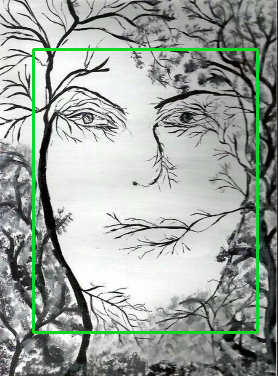

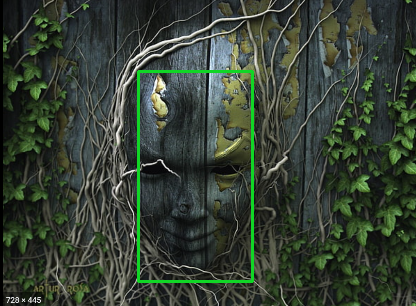

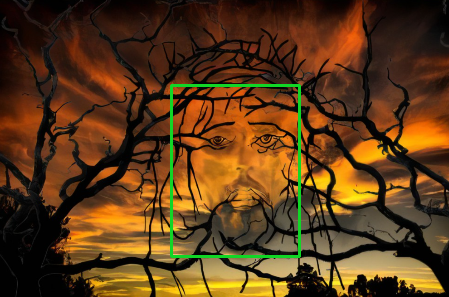

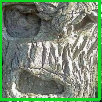

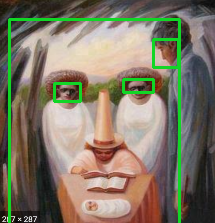

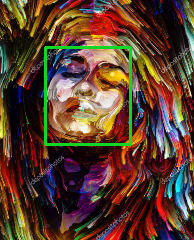

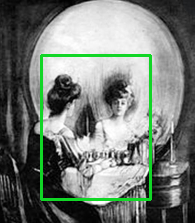

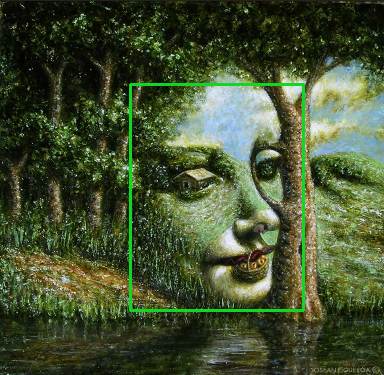

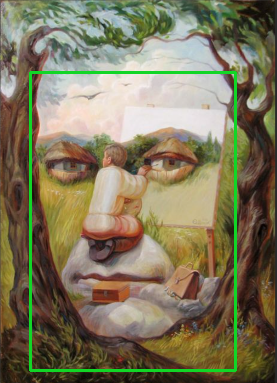

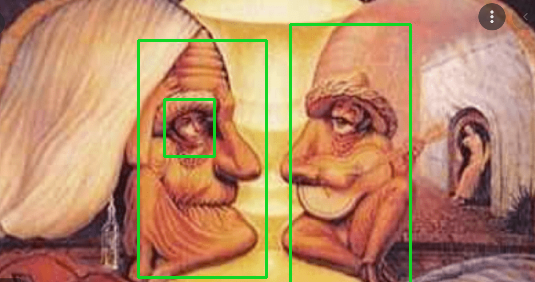

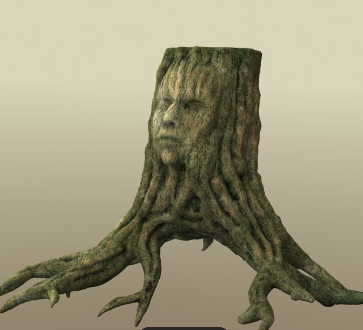

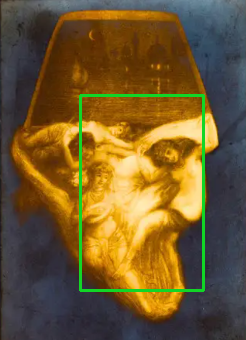

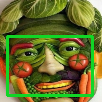

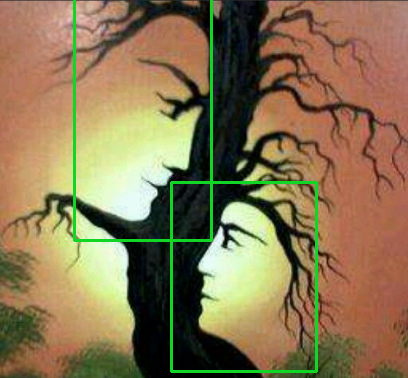

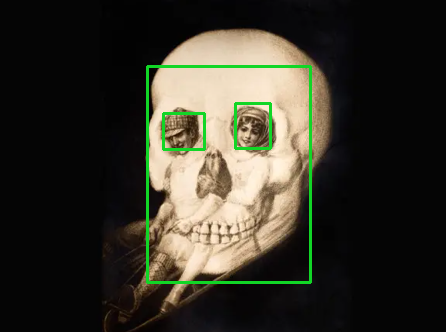

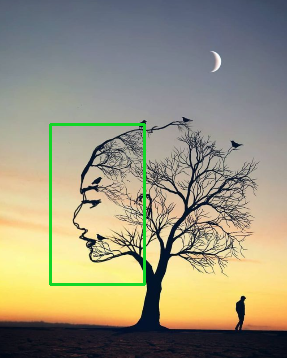

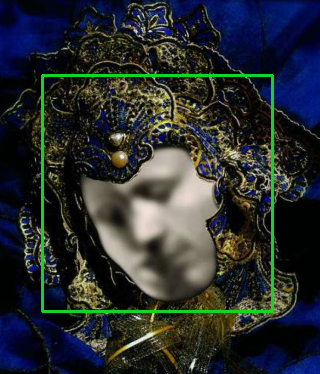

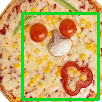

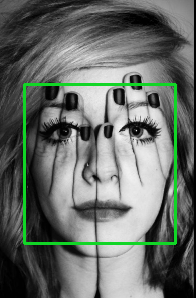

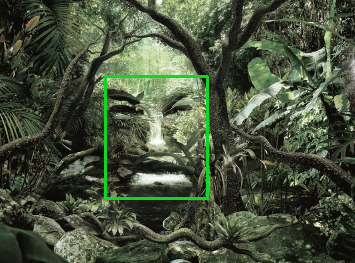

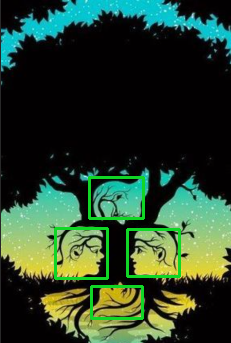

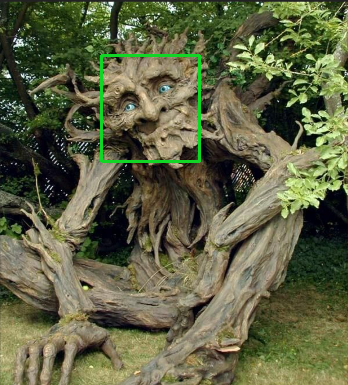

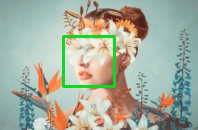

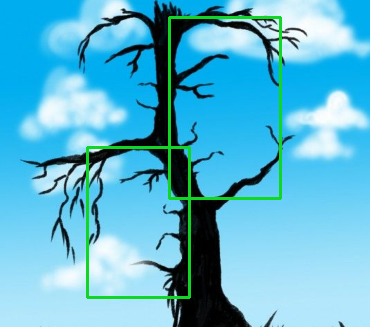

In [23]:
random.shuffle(images_path)
for img_path in images_path:
  #loading image
  img = cv2.imread(img_path)
  img = cv2.resize(img, None, fx = 0.4, fy = 0.4)
  height, width, channels = img.shape

  #detecing objects
  blob = cv2.dnn.blobFromImage(img, 0.00392, (416,416), (0,0,0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(output_layers)

  #display information
  class_ids = []
  boxes = []
  confidences = []
  for out in outs: 
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      if confidence>0.3:
        #object detection
        #print(class_id)
        center_x = int(detection[0]*width)
        center_y = int(detection[1]*height)
        w = int(detection[2]*width)
        h = int((detection[3]*height))

        #rectangle coordinates
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        boxes.append([x,y,w,h])
        confidences.append(float(confidence))
        class_ids.append(class_id)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
  #print(indexes)
  font = cv2.FONT_HERSHEY_PLAIN
  for i in range(len(boxes)):
    if i in indexes:
      x,y,w,h = boxes[i]
      label = str(classes[class_ids[i]])
      color = colors[class_ids[i]]
      cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
      #cv2.putText(img, label, (x, y+30), font, 3, color, 3)

  #cv2.imshow("Image", img)
  cv2_imshow(img)

